## Combine behavior and imaging data

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')

In [54]:
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, exists
import json
from os import mkdir, makedirs

###Set directory and session information

In [55]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [56]:
key = '2016-05-15'
name = '5001-L23'

###Load session information

In [57]:
path = join(directory, 'reprocessed', name, key, 'behavior')
print exists(path)

True


In [58]:
session = pd.read_csv(path + '/session.csv')

### Load frames per volume

In [59]:
summarypath = join(directory, 'reprocessed', name, key, 'summary')
print exists(summarypath)

True


In [60]:
with open(summarypath + '/meta.json') as infile:
    meta = json.load(infile)
framesPerVolume = meta['nplanes']
numberImagingVolumes = meta['shape'][0]

### Extract acquisition and volume trigger information

Get frame onsets and determine number of frames

In [61]:
frames = session['frames'].diff()==1
totalFrames = frames.sum()
print totalFrames

5525


Determine number of scanimage acquisitions

In [62]:
gap = 10

In [63]:
session['acquisitions'] = np.convolve(session['frames'],np.ones(gap)/gap,'same') > 0
session['acquisitions'] = session['acquisitions'].astype('float')

In [64]:
tmp = session['acquisitions'].diff()==1
session['acquisitionNumber'] = tmp.cumsum()-1
numberAcquisitions = session['acquisitionNumber'].max()+1
print numberAcquisitions

1


Convert to volumes and check if last volume trigger in each acquisition is incomplete and if so delete

In [65]:
session['volumes'] = 0
for acq in range(0,session['acquisitionNumber'].max()+1):
    currentAcq = session['acquisitionNumber'] == acq
    currentFrames = frames & currentAcq
    frameNums = currentFrames.cumsum()-1
    currentVolumes = (frameNums.mod(framesPerVolume)==0) & currentFrames
    finalVolume = np.mod(currentFrames.sum(),framesPerVolume)
    if finalVolume:
        last = np.where(currentVolumes)[0][-1]
        currentVolumes[last] = 0
    session['volumes'] = session['volumes'] | currentVolumes

In [66]:
numberVolumes = session['volumes'].sum()

###Save synchronization meta data

In [67]:
sync = {'numberAcquisitions':numberAcquisitions, 'totalFrames':totalFrames, 'framesPerVolume':framesPerVolume,
       'numberVolumes':numberVolumes}

In [68]:
print sync

{'numberAcquisitions': 1, 'totalFrames': 5525, 'numberVolumes': 5525, 'framesPerVolume': 1}


In [69]:
with open(join(path, 'sync.json'), 'w') as outfile:
    json.dump(sync, outfile, indent=2)

###Check right number of imaging volumes

In [70]:
assert(numberImagingVolumes ==  sync['numberVolumes'])

###Downsample to volumes and save results

In [71]:
covariates = session[session.volumes]

In [72]:
savepath = join(directory, 'reprocessed', name, key, 'covariates')
if not exists(savepath):
    makedirs(savepath)

In [73]:
covariates.to_csv(join(savepath, 'covariates.csv'))

# Inspect triggers

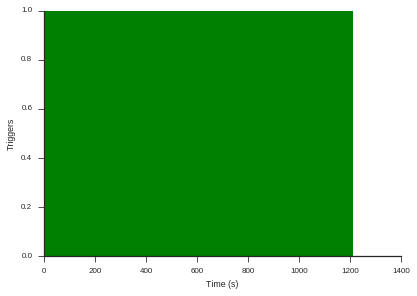

In [74]:
plt.plot(session.allTime,session.acquisitions,'r');
plt.plot(session.allTime,frames);
plt.plot(session.allTime,session.volumes,'g',linewidth=3);
plt.ylabel('Triggers')
plt.xlabel('Time (s)')
#plt.xlim([0, .5])
sns.despine()